**Лабораторная работа №3. Классификация изображений с использованием свёрточных нейронных сетей**

Калинина Е.А.

1. Загрузить сеть, предобученную на ImageNet (https://keras.io/api/applications/), выполнить классификацию изображения, найденного в интернете.
Изображение должно показывать один объект одного из следующих классов: лошадь, собака, кошка, самолёт, корабль, автомобиль, дом

In [ ]:
from keras.applications.resnet import ResNet101, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

In [ ]:
model = ResNet101(weights='imagenet')

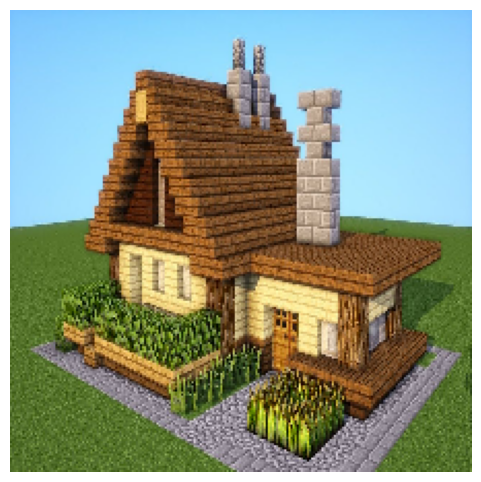

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Предсказания: [('n02727426', 'apiary', np.float32(0.24976347)), ('n02843684', 'birdhouse', np.float32(0.18339796)), ('n03877845', 'palace', np.float32(0.15109415))]


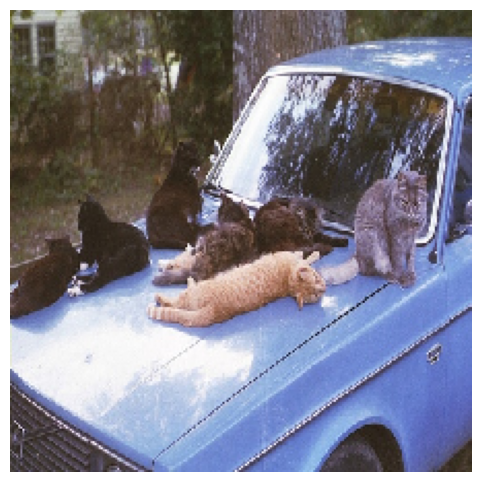

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Предсказания: [('n03930630', 'pickup', np.float32(0.26641044)), ('n03594945', 'jeep', np.float32(0.20455013)), ('n02098105', 'soft-coated_wheaten_terrier', np.float32(0.09646208))]


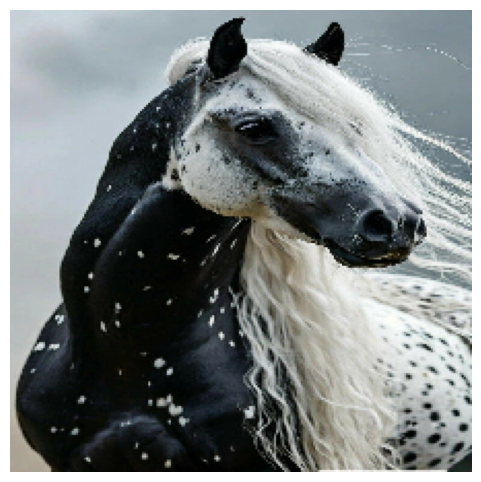

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Предсказания: [('n02091134', 'whippet', np.float32(0.39903262)), ('n02134084', 'ice_bear', np.float32(0.13128403)), ('n02113799', 'standard_poodle', np.float32(0.09899524))]


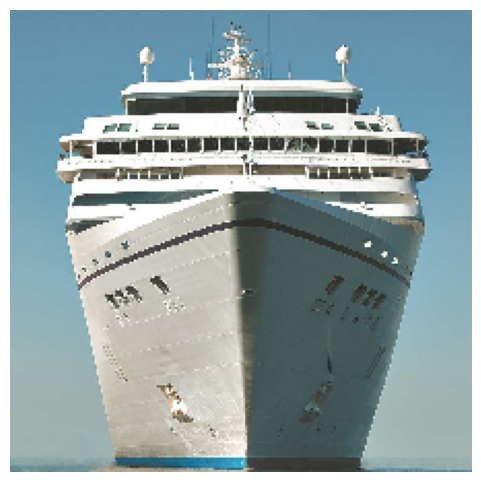

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Предсказания: [('n03673027', 'liner', np.float32(0.9962813)), ('n03216828', 'dock', np.float32(0.0032993373)), ('n02981792', 'catamaran', np.float32(0.00026799503))]


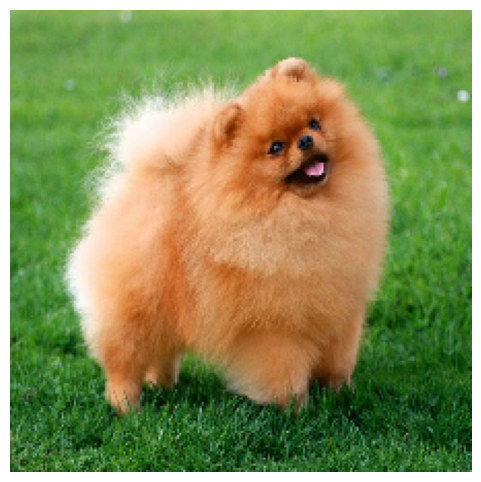

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Предсказания: [('n02112018', 'Pomeranian', np.float32(0.9903923)), ('n02112137', 'chow', np.float32(0.00736974)), ('n02112350', 'keeshond', np.float32(0.002054754))]


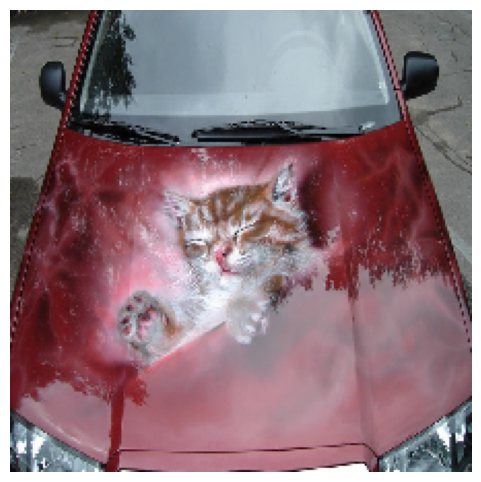

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Предсказания: [('n03770679', 'minivan', np.float32(0.34920192)), ('n02930766', 'cab', np.float32(0.31093988)), ('n02965783', 'car_mirror', np.float32(0.043983474))]


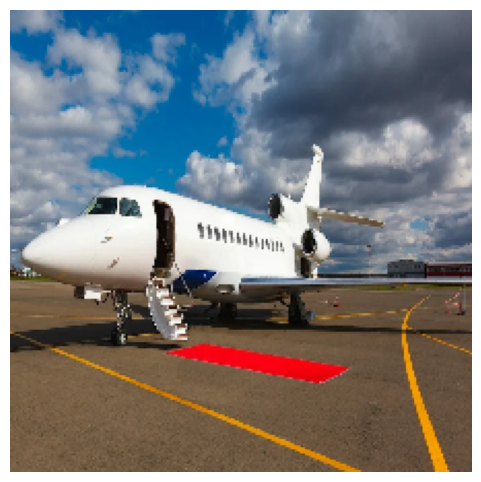

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Предсказания: [('n02690373', 'airliner', np.float32(0.9312955)), ('n04592741', 'wing', np.float32(0.0635494)), ('n04266014', 'space_shuttle', np.float32(0.0017432764))]


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

path=Path('/content/imgs')
for img_path in path.iterdir():
  img = image.load_img(img_path, target_size=(224, 224))

  plt.figure(figsize=(6, 6))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  x = image.img_to_array(img) #преобразование в numpy array
  x = np.expand_dims(x, axis=0) #добавление оси батча
  x = preprocess_input(x) #предобработка под resnet

  predictions = model.predict(x)
  print('Предсказания:', decode_predictions(predictions, top=3)[0])

2. Создать собственную сеть, обучить данную сеть с помощью генераторов на двух наборах данных: horses_or_humans, cats_vs_dogs. Оценить точность классификации сети.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def prepare_dataset(name):
    #загрузка данных
    if name=='cats_vs_dogs':
      (train_ds, test_ds) = tfds.load(
        name,
        split=['train[:70%]', 'train[70%:]'],
        shuffle_files=True,
        as_supervised=True
    )
    else:
      (train_ds, test_ds) = tfds.load(
          name,
          split=['train', 'test'],
          shuffle_files=True,
          as_supervised=True
      )

    #предобработка и масштабирование
    def preprocess(image, label):
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    #применение предобработки, разделение на батчи
    batch_size = 32
    train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds

In [ ]:
def run(train_ds, test_ds, model, epochs, title):

    callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]

    #обучение
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=test_ds,
        callbacks=callbacks
    )

    #валидация
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Точность на валидации: {test_accuracy:.4f}")

    #график обучения
    plot_training_history(history, title)

    return history, test_accuracy

In [ ]:
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    #точность
    ax1.plot(history.history['accuracy'], label='тренировка')
    ax1.plot(history.history['val_accuracy'], label='тест')
    ax1.set_title(f'{title} - точность')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность')
    ax1.legend()
    ax1.grid(True)

    #ошибка
    ax2.plot(history.history['loss'], label='тренировка')
    ax2.plot(history.history['val_loss'], label='тест')
    ax2.set_title(f'{title} - ошибка')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, class_names, num_samples=8):
    #извлечение батча изображений
    for images, labels in dataset.take(1):
        predictions = model.predict(images)

        #визуализация предсказания
        plt.figure(figsize=(12, 8))
        for i in range(min(num_samples, len(images))):
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i])

            pred_class = class_names[0] if predictions[i] < 0.5 else class_names[1]
            true_class = class_names[0] if labels[i] == 0 else class_names[1]

            color = 'green' if pred_class == true_class else 'red'
            plt.title(f'Истина: {true_class}\nПредсказание: {pred_class}', color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,503,809 (5.74 MB)

 Trainable params: 1,503,809 (5.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9607 - loss: 0.1168 - val_accuracy: 0.8320 - val_loss: 1.0324 - learning_rate: 4.0000e-05
Epoch 2/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9670 - loss: 0.0876 - val_accuracy: 0.8477 - val_loss: 1.0589 - learning_rate: 4.0000e-05
Epoch 3/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9721 - loss: 0.0851 - val_accuracy: 0.8516 - val_loss: 1.0971 - learning_rate: 4.0000e-05
Epoch 4/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9635 - loss: 0.0940 - val_accuracy: 0.8398 - val_loss: 1.0717 - learning_rate: 4.0000e-05
Epoch 5/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9762 - loss: 0.0811 - val_accuracy: 0.8516 - val_loss: 1.0467 - learning_rate: 8.0000e-06
Epoch 6/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9709 - loss: 0.0859 - val_accuracy: 0.8516 - val_loss: 1.0409 - learning_rate: 8.0000e-06
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8514 - loss: 0.8530


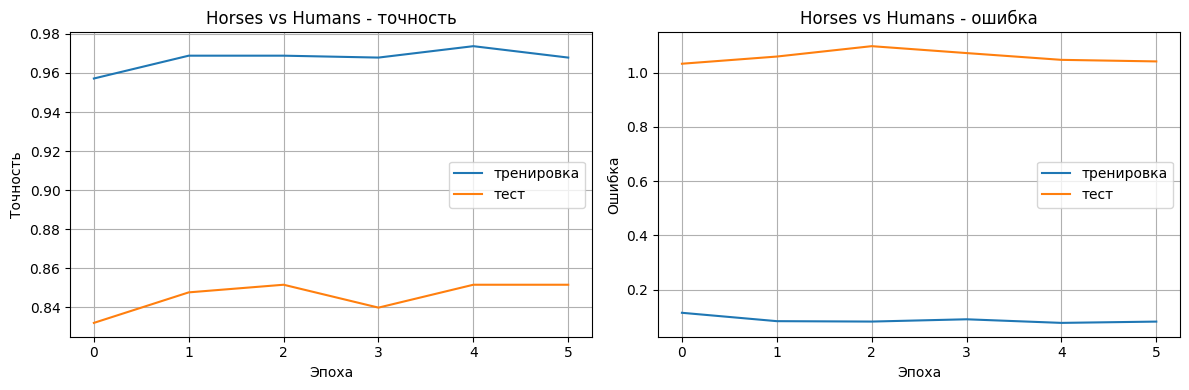

In [ ]:
train, test = prepare_dataset('horses_or_humans')
history, test_acc = run(train, test, model, 7, 'Horses vs Humans')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


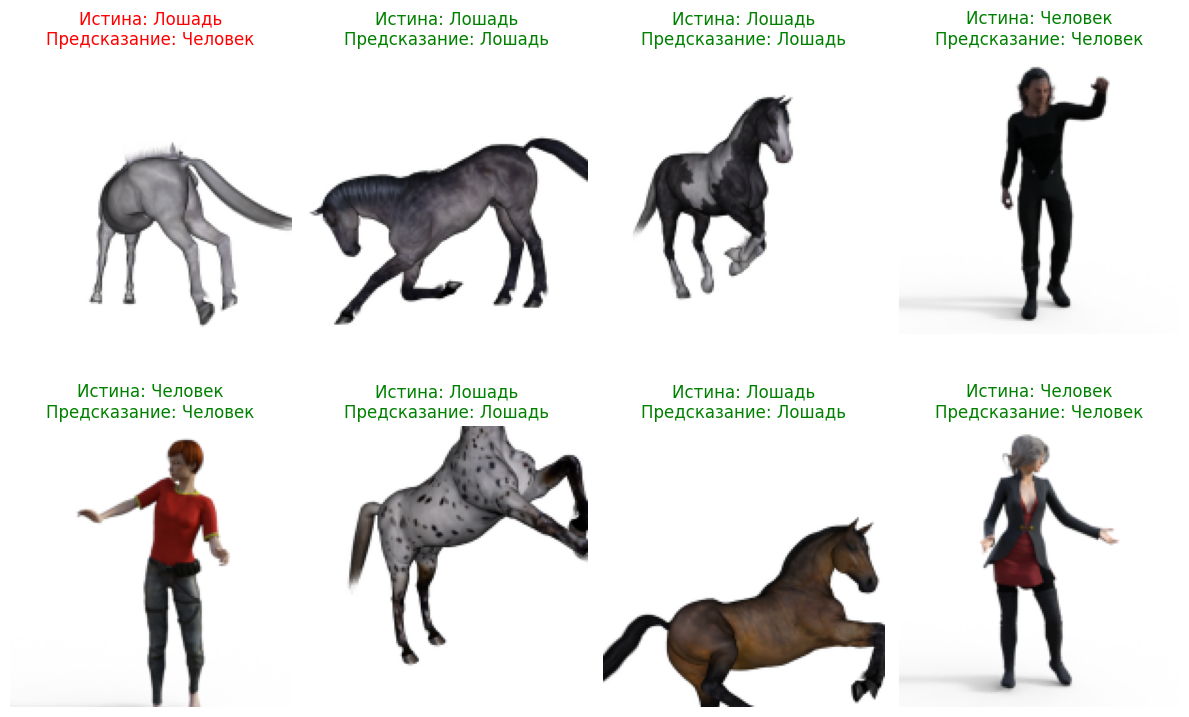

In [ ]:
visualize_predictions(model, test, ['Лошадь', 'Человек'])

Epoch 1/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.5329 - loss: 0.6863 - val_accuracy: 0.6574 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 2/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.7118 - loss: 0.5687 - val_accuracy: 0.7773 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 3/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.7910 - loss: 0.4589 - val_accuracy: 0.8224 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 4/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.8309 - loss: 0.3812 - val_accuracy: 0.8502 - val_loss: 0.3405 - learning_rate: 0.0010
Epoch 5/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.8663 - loss: 0.3092 - val_accuracy: 0.8691 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 6/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.8839 - loss: 0.2673 - val_accuracy: 0.8781 - val_loss: 0.2821 - learning_rate: 0.0010
Epoch 7/7
582/582 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.9085 - loss: 0.

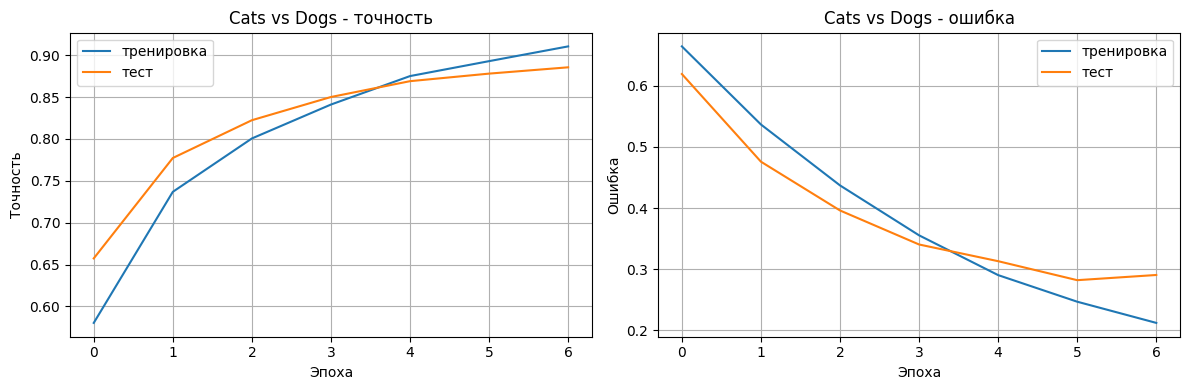

In [ ]:
train, test = prepare_dataset('cats_vs_dogs')
history, test_acc = run(train, test, model, 7, 'Cats vs Dogs')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


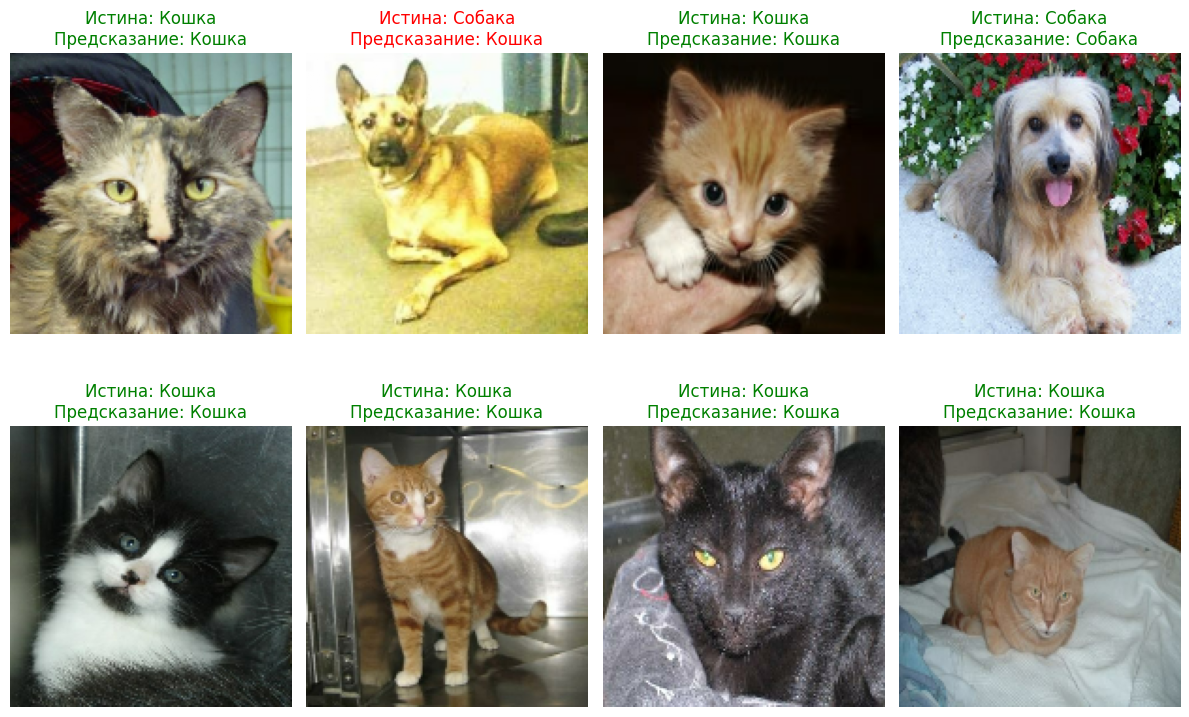

In [ ]:
visualize_predictions(model, test, ['Кошка', 'Собака'])

3. Загрузить сеть, предобученную на ImageNet, выполнить дообучение этой сети на указанном наборе данных (на двух наборах данных: horses_or_humans, cats_vs_dogs). Оценить точность классификации новой (составной) сети.

In [ ]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

In [ ]:
model = keras.Sequential([
        base_model,
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        #layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

callbacks = [
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,257,477 (218.42 MB)

 Trainable params: 4,866,433 (18.56 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 9,732,868 (37.13 MB)

In [ ]:
train_ds, test_ds = prepare_dataset('horses_or_humans')

history = model.fit(train_ds, epochs=7, validation_data=test_ds, callbacks=callbacks)
test_loss, test_accuracy = model.evaluate(test_ds)

Epoch 1/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 691ms/step - accuracy: 0.5054 - loss: 1.0904 - val_accuracy: 0.5625 - val_loss: 0.6191 - learning_rate: 0.0010
Epoch 2/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.6698 - loss: 0.6194 - val_accuracy: 0.7773 - val_loss: 0.4624 - learning_rate: 0.0010
Epoch 3/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.6934 - loss: 0.5880 - val_accuracy: 0.7578 - val_loss: 0.5559 - learning_rate: 0.0010
Epoch 4/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7710 - loss: 0.4909 - val_accuracy: 0.8008 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 5/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.7357 - loss: 0.5219 - val_accuracy: 0.8047 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 6/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.7903 - loss: 0.4824 - val_accuracy: 0.7383 - val_loss: 0.9717 - learning_rate: 2.0000e-04
Epoch 7/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.8389 - loss: 0.3609 - v

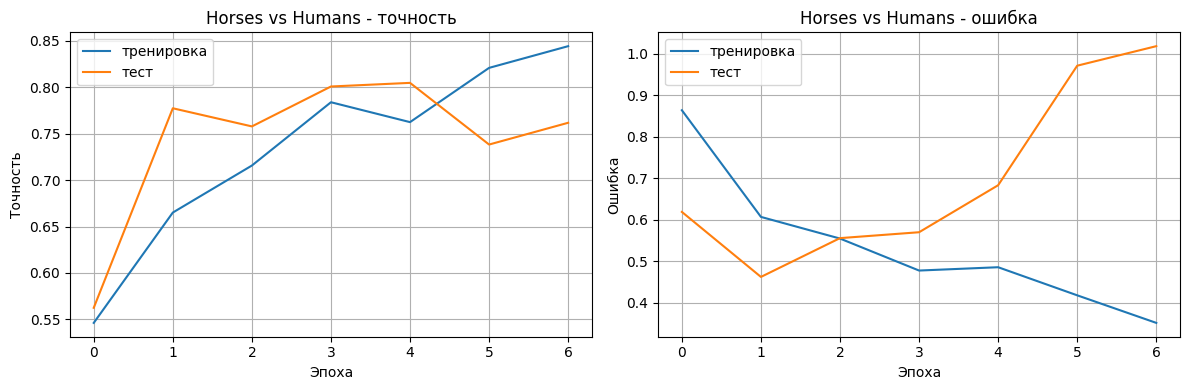

In [ ]:
plot_training_history(history, "Horses vs Humans")

In [ ]:
train_ds, test_ds = prepare_dataset('cats_vs_dogs')

history = model.fit(train_ds, epochs=7, validation_data=test_ds, callbacks=callbacks)
test_loss, test_accuracy = model.evaluate(test_ds)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Epoch 1/7
509/509 ━━━━━━━━━━━━━━━━━━━━ 136s 267ms/step - accuracy: 0.5545 - loss: 0.7188 - val_accuracy: 0.6143 - val_loss: 0.6524 - learning_rate: 2.0000e-04
Epoch 2/7
509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 235ms/step - accuracy: 0.6301 - loss: 0.6453 - val_accuracy: 0.6537 - val_loss: 0.6249 - learning_rate: 2.0000e-04
Epoch 3/7
509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 236ms/step - accuracy: 0.6576 - loss: 0.6259 - val_accuracy: 0.6849 - val_loss: 0.6008 - learning_rate: 2.0000e-04
Epoch 4/7
509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 235ms/step - accuracy: 0.6779 - loss: 0.6056 - val_accuracy: 0.7083 - val_loss: 0.5820 - learning_rate: 2.0000e-04
Epoch 5/7
509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 235ms/step - accuracy: 0.6959 - loss: 0.5894 - val_accuracy: 0.7035 - val_loss: 0.5744 - learning_rate: 2.0000e-04
Epoch 6/7
509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 236ms/step - accuracy: 0.701

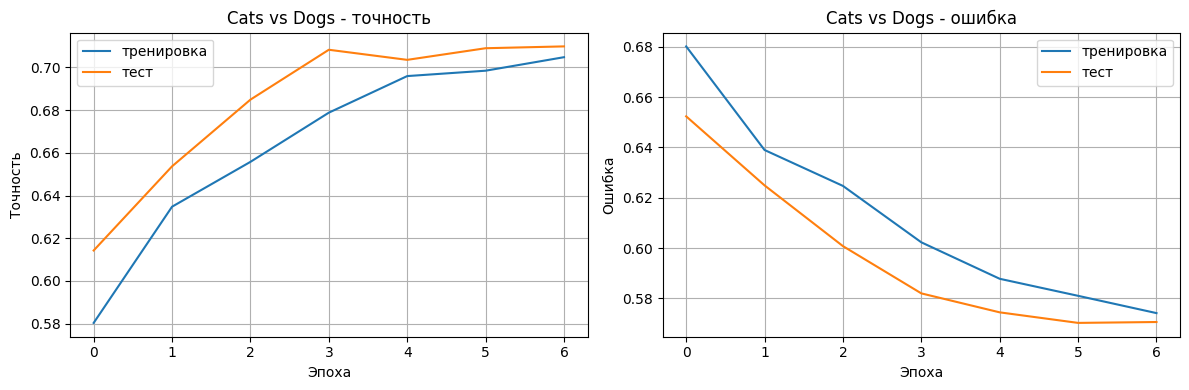

In [ ]:
plot_training_history(history, "Cats vs Dogs")